# Find A Raster Tile

**Goal**: Find the raster tile your pit falls in.

**Approach**: 
1. Grab the pit location from the a pit layer in the database
2. Perform an intersect on all raster tiles with the pit location 
3. Plot 


### Step 1. Grab the pit location from the layer data

In [1]:
from snowexsql.db import get_db
from snowexsql.data import ImageData, LayerData
from rasterio.plot import show
from sqlalchemy.sql import func
import geoalchemy2.functions as gfunc
from geoalchemy2.shape import to_shape
from rasterio import MemoryFile
import matplotlib.pyplot as plt
import geopandas as gpd
from snowexsql.conversions import raster_to_rasterio

# PIT Site Identifier
site_id = '5S31'

# Connect to the database we made.
db_name = 'db.snowexdata.org/snowex'
engine, session = get_db(db_name, credentials='./credentials.json')

# Grab our pit layers by site id
q = session.query(LayerData).filter(LayerData.site_id == site_id)
layers = q.all()

# Grab the pit location from a single layerdata entry
p = layers[0].geom
p_shp = to_shape(p)

### Step 2. Perform an intersect on all raster tiles with the pit location 

In [2]:
# Grab the raster as a tile that intersects with our pit and convert it to a geotiff
print('Grabbing rasters that overlap on the point {}'.format(p_shp))

# Grab the returned raster as a tiff
q = session.query(func.ST_AsTiff(ImageData.raster)).filter(ImageData.observers=='ASO Inc.')
q = q.filter(ImageData.type=='depth')

# Filter rasters by where a tile intersects wihtour pit location
rasters = q.filter(gfunc.ST_Intersects(ImageData.raster, p)).all()

# Convert it to a rasterio dataset for easy plotting
dataset = raster_to_rasterio(session, rasters)[0]


Grabbing rasters that overlap on the point POINT (745458 4322762)


### Step 3. Plot it up! 

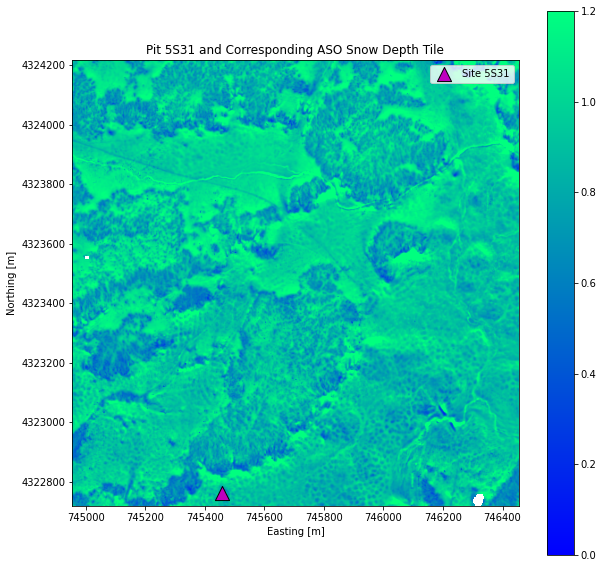

In [3]:
fig,ax = plt.subplots(figsize=(10,10))

# Plot the rasterio dataset
tile = dataset.read(1)
show(tile, ax=ax, transform=dataset.transform, cmap='winter', vmin=0, vmax=1.2) 
fig.colorbar(ax.images[0])

# Add to our plot the pit location
gpd.GeoSeries(p_shp).plot(ax=ax, color='m', edgecolor='black', markersize=200,  marker='^', label="Site {}".format(site_id))

# Add some labeling
ax.ticklabel_format(style='plain', useOffset=False)
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('Pit {} and Corresponding ASO Snow Depth Tile'.format(site_id))
ax.legend()

In [4]:
# Close the session to avoid hanging transactions
session.close()